# load packages and data

In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U 'spacy[cuda12x]'
# !python -m spacy download en_core_web_sm
# !python -m spacy download ru_core_news_sm
# !python -m spacy download ru_core_news_md

In [ ]:
import spacy

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir_path = '/content/drive/MyDrive/ML Project/data/'
train_featured = pd.read_csv(data_dir_path + 'train_X_y_features_v1.csv')
test_featured = pd.read_csv( data_dir_path + 'test_X_y_features_v1.csv')
print(train_featured.shape)
print(test_featured.shape)

(1202739, 43)
(300685, 43)


In [ ]:
# train_featured.agg("{0[title]}; {0[description]}".format, axis=1)
train_text_df = train_featured.loc[:, ["item_id", "user_id",]].copy()
train_text_df["text"] = train_featured["title"].fillna("") + "; " \
    + train_featured["description"].fillna("")

test_text_df = test_featured.loc[:, ["item_id", "user_id",]].copy()
test_text_df["text"] = test_featured["title"].fillna("") + "; " \
    + test_featured["description"].fillna("")

# Text embedding - small spacy model

In [ ]:
NLP = spacy.load('ru_core_news_sm', disable=["ner", "parser"])

In [ ]:
import os
n_process = os.cpu_count()
print(n_process)

8


In [ ]:
# tqdm.pandas(desc="generate embeddings")
# train_text_df["embeddings"] = train_text_df["text"].progress_apply(lambda x: NLP(x).vector)

In [ ]:
train_texts = train_text_df["text"].tolist()
embeddings = []
for doc in tqdm(NLP.pipe(train_texts, n_process=n_process, batch_size=100), total=len(train_texts)):
    embeddings.append(doc.vector)
# train_text_df["embeddings"] = embeddings

In [ ]:
train_text_df = pd.concat([
    train_text_df.drop(columns=["text"]),
    pd.DataFrame(np.array(embeddings)).add_prefix("embedding_")
    ], axis=1,
)

In [ ]:
train_text_df.to_csv(data_dir_path + 'train_embeddings_spacysm.csv', index=False)

In [ ]:
test_texts = test_text_df["text"].tolist()
embeddings = []
for doc in tqdm(NLP.pipe(test_texts, n_process=n_process, batch_size=100), total=len(test_texts)):
    embeddings.append(doc.vector)
# test_text_df["embeddings"] = embeddings
test_text_df = pd.concat([
    test_text_df.drop(columns=["text"]),
    pd.DataFrame(np.array(embeddings)).add_prefix("embedding_")
    ], axis=1,
)
test_text_df.to_csv(data_dir_path + 'test_embeddings_spacysm.csv', index=False)

100%|██████████| 300685/300685 [11:49<00:00, 423.54it/s]


# Text embedding - medium spacy model

In [ ]:
NLP = spacy.load('ru_core_news_md', disable=["ner", "parser"])

In [ ]:
import os
n_process = os.cpu_count()
print(n_process)

8


In [ ]:
train_texts = train_text_df["text"].tolist()
embeddings = []
for doc in tqdm(NLP.pipe(train_texts, n_process=n_process, batch_size=100), total=len(train_texts)):
    embeddings.append(doc.vector)
# train_text_df["embeddings"] = embeddings
train_text_df = pd.concat([
    train_text_df.drop(columns=["text"]),
    pd.DataFrame(np.array(embeddings)).add_prefix("embedding_")
    ], axis=1,
)
# train_text_df.to_csv(data_dir_path + 'train_embeddings_spacymd.csv', index=False)

100%|██████████| 1202739/1202739 [51:36<00:00, 388.38it/s]


In [ ]:
test_texts = test_text_df["text"].tolist()
embeddings = []
for doc in tqdm(NLP.pipe(test_texts, n_process=n_process, batch_size=100), total=len(test_texts)):
    embeddings.append(doc.vector)
# test_text_df["embeddings"] = embeddings
test_text_df = pd.concat([
    test_text_df.drop(columns=["text"]),
    pd.DataFrame(np.array(embeddings)).add_prefix("embedding_")
    ], axis=1,
)
# test_text_df.to_csv(data_dir_path + 'test_embeddings_spacymd.csv', index=False)

100%|██████████| 300685/300685 [13:31<00:00, 370.44it/s]


In [ ]:
# train_text_df.to_csv(data_dir_path + 'train_embeddings_spacymd.csv', index=False)
# test_text_df.to_csv(data_dir_path + 'test_embeddings_spacymd.csv', index=False)

# Helper functions and shared params for LightGBM

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import TruncatedSVD

In [ ]:
# load data and merge with embeddings
def get_tabulat_and_text_data(train_text_df, test_text_df):
    train_X = train_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
        'image_top_1', 'deal_probability'], axis=1)
    test_X = test_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
        'image_top_1', 'deal_probability'], axis=1)
    train_y = train_featured['deal_probability']
    test_y = test_featured['deal_probability']

    categorical_features = train_X.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_features:
        train_X[col] = train_X[col].astype('category')
        test_X[col] = test_X[col].astype('category')

    if "item_id" in train_text_df.columns:
        train_X = pd.concat([train_X, train_text_df.drop(columns=["item_id", "user_id"])], axis=1)
        test_X = pd.concat([test_X, test_text_df.drop(columns=["item_id", "user_id"])], axis=1)
    else:
        train_X = pd.concat([train_X, train_text_df], axis=1)
        test_X = pd.concat([test_X, test_text_df], axis=1)

    return train_X, test_X, train_y, test_y, categorical_features

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 512,
    'max_depth': 20,
    'bagging_seed': 42,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'lambda_l1': 2.25,
    'lambda_l2': 0.015,
    'verbose': -1
}

In [ ]:
def fit_lgb(
        train_X, train_y, test_X, test_y, categorical_features,
        params,
        num_boost_round=3000,
        early_stopping_rounds=50,
        eval_period=40,
    ):

    # validation set for early stopping
    train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42, shuffle=True
    )
    lgb_train = lgb.Dataset(
        train_X_split, label=train_y_split, categorical_feature=categorical_features
    )
    lgb_val = lgb.Dataset(
        val_X_split, label=val_y_split, categorical_feature=categorical_features,
        reference=lgb_train
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=eval_period)
    ]

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks
    )

    preds = model.predict(test_X, num_iteration=model.best_iteration)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print(f"RMSE: {rmse}")

    return model

In [ ]:
def get_feature_importance(model):
    feature_importances = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance()
    }).sort_values(by='importance', ascending=False)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(feature_importances)
    return feature_importances

# LightGBM with Small Spacy embedding

In [ ]:
train_text_df = pd.read_csv(data_dir_path + 'train_embeddings_spacysm.csv')
test_text_df = pd.read_csv(data_dir_path + 'test_embeddings_spacysm.csv')

train_X, test_X, train_y, test_y, categorical_features = get_tabulat_and_text_data(train_text_df, test_text_df)

### Embedding only tree

In [ ]:
# convergence too slow with embedding only data
text_only_params = params.copy()
text_only_params['learning_rate'] = 0.1

model_text_sm = fit_lgb(
    train_text_df.drop(columns=["item_id", "user_id"]), train_y,
    test_text_df.drop(columns=["item_id", "user_id"]), test_y,
    [],
    text_only_params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.243146	valid_1's rmse: 0.252092
[80]	training's rmse: 0.234956	valid_1's rmse: 0.250845
[120]	training's rmse: 0.228123	valid_1's rmse: 0.250425
[160]	training's rmse: 0.222002	valid_1's rmse: 0.25029
[200]	training's rmse: 0.216531	valid_1's rmse: 0.250291
Early stopping, best iteration is:
[169]	training's rmse: 0.2207	valid_1's rmse: 0.250277
RMSE: 0.24878014575748553


### Tabular with full embedding

In [ ]:
model_sm = fit_lgb(
    train_X, train_y,
    test_X, test_y,
    categorical_features,
    params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.232733	valid_1's rmse: 0.237519
[80]	training's rmse: 0.223266	valid_1's rmse: 0.231472
[120]	training's rmse: 0.218458	valid_1's rmse: 0.229795
[160]	training's rmse: 0.215113	valid_1's rmse: 0.22921
[200]	training's rmse: 0.212666	valid_1's rmse: 0.228951
[240]	training's rmse: 0.210917	valid_1's rmse: 0.228848
[280]	training's rmse: 0.209374	valid_1's rmse: 0.228738
[320]	training's rmse: 0.207998	valid_1's rmse: 0.228682
[360]	training's rmse: 0.206763	valid_1's rmse: 0.22865
[400]	training's rmse: 0.20557	valid_1's rmse: 0.228611
[440]	training's rmse: 0.204539	valid_1's rmse: 0.228581
[480]	training's rmse: 0.20339	valid_1's rmse: 0.228534
[520]	training's rmse: 0.202432	valid_1's rmse: 0.228521
[560]	training's rmse: 0.201594	valid_1's rmse: 0.228529
Early stopping, best iteration is:
[522]	training's rmse: 0.20239	valid_1's rmse: 0.22852
RMSE: 0.22696851561639192


### Truncated SVD on Embeddings

#### Choosing K

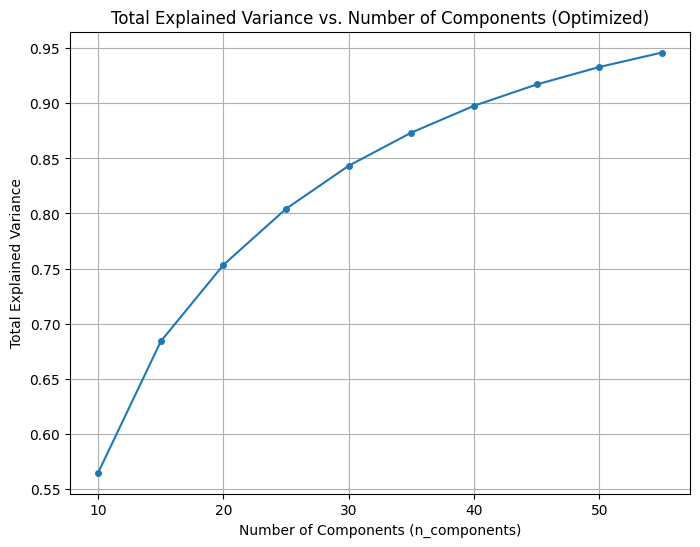

In [ ]:
explained_variances = []
n_components_range = range(10, 60, 5)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(train_text_df.drop(columns=["item_id", "user_id"]))
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
n_components = 40
svd = TruncatedSVD(n_components=n_components, random_state=42)

# fit using train, then transform-only on the test
train_text_svd = svd.fit_transform(train_text_df.drop(columns=["item_id", "user_id"]))
test_text_svd = svd.transform(test_text_df.drop(columns=["item_id", "user_id"]))

total_explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by {n_components} components: {total_explained_variance:.2f}")

train_text_svd = pd.DataFrame(train_text_svd, columns=[f"svd_{i}" for i in range(n_components)])
test_text_svd = pd.DataFrame(test_text_svd, columns=[f"svd_{i}" for i in range(n_components)])

Total explained variance by 40 components: 0.90


#### Re-fit LightGBM with SVD

In [ ]:
train_X, test_X, train_y, test_y, categorical_features = get_tabulat_and_text_data(train_text_svd, test_text_svd)

In [ ]:
model_svd_sm = fit_lgb(
    train_X, train_y,
    test_X, test_y,
    categorical_features,
    params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.232753	valid_1's rmse: 0.237398
[80]	training's rmse: 0.223638	valid_1's rmse: 0.231456
[120]	training's rmse: 0.219014	valid_1's rmse: 0.229781
[160]	training's rmse: 0.215951	valid_1's rmse: 0.229224
[200]	training's rmse: 0.213857	valid_1's rmse: 0.229031
[240]	training's rmse: 0.212259	valid_1's rmse: 0.228927
[280]	training's rmse: 0.210838	valid_1's rmse: 0.228859
[320]	training's rmse: 0.209763	valid_1's rmse: 0.228818
[360]	training's rmse: 0.208495	valid_1's rmse: 0.228756
[400]	training's rmse: 0.20739	valid_1's rmse: 0.22871
[440]	training's rmse: 0.206426	valid_1's rmse: 0.228683
[480]	training's rmse: 0.205523	valid_1's rmse: 0.228652
[520]	training's rmse: 0.204801	valid_1's rmse: 0.228643
[560]	training's rmse: 0.204193	valid_1's rmse: 0.228647
Early stopping, best iteration is:
[535]	training's rmse: 0.204588	valid_1's rmse: 0.228637
RMSE: 0.22711105848926472


# LightGBM with Medium Spacy embedding

In [ ]:
train_text_df = pd.read_csv(data_dir_path + 'train_embeddings_spacymd.csv')
test_text_df = pd.read_csv(data_dir_path + 'test_embeddings_spacymd.csv')

train_X, test_X, train_y, test_y, categorical_features = get_tabulat_and_text_data(train_text_df, test_text_df)

### Embedding only tree

In [ ]:
# convergence too slow with embedding only data
text_only_params = params.copy()
text_only_params['learning_rate'] = 0.1

model_text_md = fit_lgb(
    train_text_df.drop(columns=["item_id", "user_id"]), train_y,
    test_text_df.drop(columns=["item_id", "user_id"]), test_y,
    [],
    text_only_params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.238705	valid_1's rmse: 0.249631
[80]	training's rmse: 0.229124	valid_1's rmse: 0.248456
[120]	training's rmse: 0.221152	valid_1's rmse: 0.248077
[160]	training's rmse: 0.214078	valid_1's rmse: 0.248002
[200]	training's rmse: 0.207731	valid_1's rmse: 0.248035
Early stopping, best iteration is:
[164]	training's rmse: 0.213415	valid_1's rmse: 0.247987
RMSE: 0.24628905449067373


### Tabular with full embedding

In [ ]:
model_md = fit_lgb(
    train_X, train_y,
    test_X, test_y,
    categorical_features,
    params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.232534	valid_1's rmse: 0.237417
[80]	training's rmse: 0.222868	valid_1's rmse: 0.231317
[120]	training's rmse: 0.217816	valid_1's rmse: 0.229549
[160]	training's rmse: 0.214366	valid_1's rmse: 0.228925
[200]	training's rmse: 0.211778	valid_1's rmse: 0.22865
[240]	training's rmse: 0.209909	valid_1's rmse: 0.22854
[280]	training's rmse: 0.2084	valid_1's rmse: 0.22847
[320]	training's rmse: 0.207	valid_1's rmse: 0.22842
[360]	training's rmse: 0.205665	valid_1's rmse: 0.228376
[400]	training's rmse: 0.204421	valid_1's rmse: 0.228345
[440]	training's rmse: 0.203123	valid_1's rmse: 0.22831
[480]	training's rmse: 0.201909	valid_1's rmse: 0.22829
[520]	training's rmse: 0.20083	valid_1's rmse: 0.228279
[560]	training's rmse: 0.199834	valid_1's rmse: 0.22826
[600]	training's rmse: 0.198853	valid_1's rmse: 0.22824
[640]	training's rmse: 0.197976	valid_1's rmse: 0.228242
Early stopping, best iteration is:
[614]	tr

### Truncated SVD on Embeddings

#### Choosing K

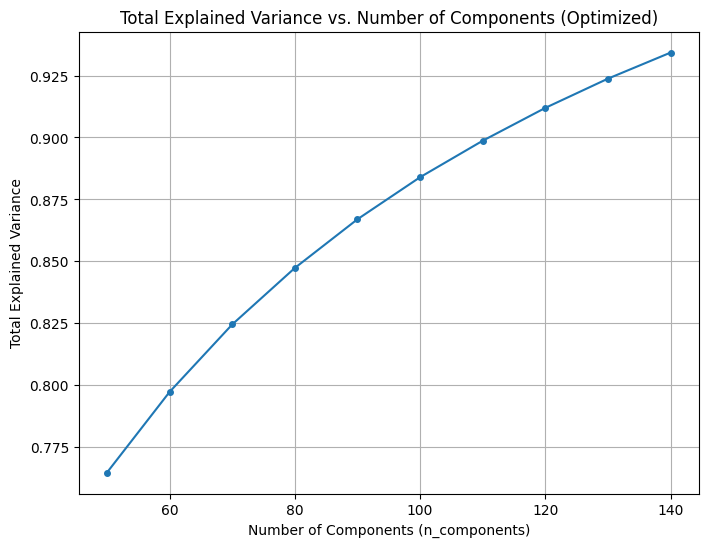

In [ ]:
explained_variances = []
n_components_range = range(50, 150, 10)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(train_text_df.drop(columns=["item_id", "user_id"]))
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)

# fit using train, then transform-only on the test
train_text_svd = svd.fit_transform(train_text_df.drop(columns=["item_id", "user_id"]))
test_text_svd = svd.transform(test_text_df.drop(columns=["item_id", "user_id"]))

total_explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by {n_components} components: {total_explained_variance:.2f}")

train_text_svd = pd.DataFrame(train_text_svd, columns=[f"svd_{i}" for i in range(n_components)])
test_text_svd = pd.DataFrame(test_text_svd, columns=[f"svd_{i}" for i in range(n_components)])

Total explained variance by 100 components: 0.88


#### Re-fit LightGBM with SVD

In [ ]:
train_X, test_X, train_y, test_y, categorical_features = get_tabulat_and_text_data(train_text_svd, test_text_svd)

In [ ]:
model_svd_md = fit_lgb(
    train_X, train_y,
    test_X, test_y,
    categorical_features,
    params,
)

Training until validation scores don't improve for 50 rounds
[40]	training's rmse: 0.232698	valid_1's rmse: 0.237385
[80]	training's rmse: 0.223322	valid_1's rmse: 0.23139
[120]	training's rmse: 0.218523	valid_1's rmse: 0.229703
[160]	training's rmse: 0.215306	valid_1's rmse: 0.229163
[200]	training's rmse: 0.212925	valid_1's rmse: 0.228914
[240]	training's rmse: 0.211248	valid_1's rmse: 0.228828
[280]	training's rmse: 0.209573	valid_1's rmse: 0.228702
[320]	training's rmse: 0.208437	valid_1's rmse: 0.228694
[360]	training's rmse: 0.207155	valid_1's rmse: 0.228647
[400]	training's rmse: 0.206002	valid_1's rmse: 0.228627
[440]	training's rmse: 0.204865	valid_1's rmse: 0.228588
[480]	training's rmse: 0.203784	valid_1's rmse: 0.228559
[520]	training's rmse: 0.202796	valid_1's rmse: 0.22854
[560]	training's rmse: 0.20199	valid_1's rmse: 0.228548
Early stopping, best iteration is:
[538]	training's rmse: 0.202403	valid_1's rmse: 0.228532
RMSE: 0.22700914577056955
